In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Load and normalize CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



Datasets & Dataloaders
----------------------------

read this website for more details: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [22]:
transform = transforms.Compose( # put several transform operation together
    [transforms.ToTensor(),    # convert a iamge to a tesnor of the same type
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # normalize, mean in first parenthesis and std in the second

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)  # define the transform operation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # use dataloader to prepare data for training and testing
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [17]:
print(trainset)
print(testset)
print(trainset[0])

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
       

In [23]:
# how to read the iamge from trainloader (every time it iterates, it gets a mini-batch)
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4])


Let us show some of the training images, for fun.



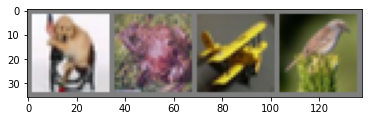

  dog  frog plane  bird


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [24]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # here input (an image) has three channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [26]:
# my writing
for epoch in range(3): # loop over the data-set three times
    
    loss_total = 0
    # loop each mini-batch (with batch_size = 4 images)
    for i, data in enumerate(trainloader,0):
        
        # in each time when a new minibatch comes in, we need to zero-buffer the gradient
        optimizer.zero_grad()
        
        # get the images and the labels
        images,labels = data
        
        # input the images into the net
        output = net(images)
        
        # get the loss
        loss = criterion(output, labels)
        
        # get the backward pass
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        # report the loss every 1000 batches
        loss_total += loss.item()
        
        if i % 1000 == 999:
            print('now we are at epoch ',str(epoch + 1), ' batch ',str(i + 1), ' the loss is ', loss_total / (1000))
            loss_total = 0
        
print('finished training')

now we are at epoch  1  batch  1000  the loss is  2.241926448106766
now we are at epoch  1  batch  2000  the loss is  1.9819060479402542
now we are at epoch  1  batch  3000  the loss is  1.8413490107655526
now we are at epoch  1  batch  4000  the loss is  1.7694254363775253
now we are at epoch  1  batch  5000  the loss is  1.6740994544625283
now we are at epoch  1  batch  6000  the loss is  1.6451461462378503
now we are at epoch  1  batch  7000  the loss is  1.604709980249405
now we are at epoch  1  batch  8000  the loss is  1.5557669111788273
now we are at epoch  1  batch  9000  the loss is  1.4978429111093283
now we are at epoch  1  batch  10000  the loss is  1.4701542845070361
now we are at epoch  1  batch  11000  the loss is  1.475169461429119
now we are at epoch  1  batch  12000  the loss is  1.439883835747838
now we are at epoch  2  batch  1000  the loss is  1.3979382199943067
now we are at epoch  2  batch  2000  the loss is  1.3418474068641664
now we are at epoch  2  batch  3000

In [15]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # enumerate(iterable, start = 0)
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
       
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()  # the loss.item() method extracts the loss's value as a python float
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            running_loss = 0.0

            
        

print('Finished Training')

[1,  2000] loss: 2.174
[1,  4000] loss: 1.807
[1,  6000] loss: 1.640
[1,  8000] loss: 1.567
[1, 10000] loss: 1.497
[1, 12000] loss: 1.459
[2,  2000] loss: 1.376
[2,  4000] loss: 1.360
[2,  6000] loss: 1.318
[2,  8000] loss: 1.284
[2, 10000] loss: 1.284
[2, 12000] loss: 1.260
Finished Training


Let's quickly save our trained model:



In [31]:
# get the gradient
print(net.fc1.bias.grad.size())

# what is state_dict - get the current value of each weights and bias as well as each optimizer
# Print model's state_dict

print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
    # print(param_tensor, "\t", net.state_dict()[param_tensor]) get values

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

torch.Size([120])
Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[[[-0.5323, -0.6104, -0.7119, -0.7920, -0.8072],
          [-0.5363, -0.6545, -0.7910, -0.8439, -0.8392],
          [-0.5809, -0.6971, -0.8201, -0.8186, -0.7743],
          [-0.6361, -0.7142, -0.7534, -0.7173, -0.6612],
          [-0.6641, -0.7073, -0.7228, -0.6948, -0.6320]],

         [[-0.3043, -0.3760, -0.4548, -0.5003, -0.5055],
          [-0.2772, -0.3968, -0.5366, -0.5688, -0.5500],
          [-0.3104, -0.4269, -0.5492, -0.5474, -0.5043],
          [-0.3763, -0.4334, -0.4592, -0.4356, -0.3958],
          [-0.3971, -0.4157, -0.4128, -0.3931, -0.3463]],

  

In [32]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)  # a state_dickt is simply a python dictionary object that maps each layer to its parameter tensor

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

# 5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Remember we must use torch.no_grad() since no need for gradient calculation in testing
------------------

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



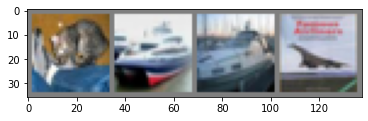

GroundTruth:    cat  ship  ship plane


In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [34]:
net = Net()
net.load_state_dict(torch.load(PATH)) # load the saved model

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [38]:
outputs = net(images)
print(outputs.size())

torch.Size([4, 10])


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [40]:
_, predicted = torch.max(outputs, 1) # find the value and the index of the maximum

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [42]:
a = torch.tensor([2,3,4])
b = torch.tensor([2,3,4])
print(sum(a==b))

tensor(3)


In [44]:
correct_cases = 0
with torch.no_grad(): # IMPORTANT since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(testloader, 0): # enumerate(iterable, start = 0)

            # get the inputs; data is a list of [inputs, labels]
            inputs, groundtruth_labels = data

            # outputs
            outputs = net(inputs)

            # get the class predictions
            _, predicted = torch.max(outputs, 1)

            # how many cases in this batch are correct?
            num = sum(groundtruth_labels == predicted)

            correct_cases += num


accuracy is  tensor(2.3609)


In [45]:
accuracy = correct_cases / i /4
print('accuracy is ',accuracy)

accuracy is  tensor(0.5902)


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [43]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [46]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 64.2 %
Accuracy for class car   is: 71.4 %
Accuracy for class bird  is: 56.5 %
Accuracy for class cat   is: 45.7 %
Accuracy for class deer  is: 49.7 %
Accuracy for class dog   is: 29.8 %
Accuracy for class frog  is: 73.3 %
Accuracy for class horse is: 65.8 %
Accuracy for class ship  is: 77.9 %
Accuracy for class truck is: 55.7 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


